In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams["font.family"] = "serif"

In [2]:
def compute_coverage_probs(true_values, ci_lower, ci_upper):
    """Compute empirical coverage probabilities.
    
    Args:
        true_values: Ground truth values, shape (n_samples,)
        ci_lower: Lower bounds of credible intervals, shape (n_samples, n_confidence_levels)
        ci_upper: Upper bounds of credible intervals, shape (n_samples, n_confidence_levels)
    
    Returns:
        Coverage probabilities for each confidence level, shape (n_confidence_levels,)
    """
    coverage = (ci_lower <= true_values.unsqueeze(-1)) * (true_values.unsqueeze(-1) <= ci_upper)
    return coverage.float().mean(0)

In [3]:
def plot_coverage_probs(confidence_levels, shear1_coverage_probs, shear2_coverage_probs, save_path=None):
    """Plot nominal vs empirical coverage probabilities.
    
    Args:
        confidence_levels: Nominal confidence levels
        shear1_coverage_probs: Empirical coverage for shear1
        shear2_coverage_probs: Empirical coverage for shear2
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    color = "#1c692b"
    s = 40

    _ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[0].scatter(confidence_levels, shear1_coverage_probs, color=color, s=s, zorder=1)
    _ = ax[0].set_title(r"$\gamma_1$", fontsize=16)
    _ = ax[0].set_xlabel("Nominal coverage", fontsize=fontsize)
    _ = ax[0].xaxis.set_label_coords(1.2, -0.15)
    _ = ax[0].set_ylabel("Empirical coverage", fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
    _ = ax[0].set_xlim(0, 1)
    _ = ax[0].set_ylim(0, 1)

    _ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[1].scatter(confidence_levels, shear2_coverage_probs, color=color, s=s, zorder=1)
    _ = ax[1].set_title(r"$\gamma_2$", fontsize=16)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
    _ = ax[1].set_xlim(0, 1)
    _ = ax[1].set_ylim(0, 1)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)

    _ = fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

In [4]:
def plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    interval_idx=17, n_display=1000, seed=0, save_path=None
):
    """Plot credible intervals showing coverage.
    
    Args:
        shear1_true: Ground truth shear1 values
        shear2_true: Ground truth shear2 values
        shear1_ci_lower: Lower bounds for shear1 CIs
        shear1_ci_upper: Upper bounds for shear1 CIs
        shear2_ci_lower: Lower bounds for shear2 CIs
        shear2_ci_upper: Upper bounds for shear2 CIs
        interval_idx: Index of confidence level to plot (default 17 = 90%)
        n_display: Number of samples to display
        seed: Random seed for sample selection
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    color = np.array(["#c26d27", "#1c692b"])
    alpha = 0.5
    axmin = -0.06
    axmax = 0.06

    np.random.seed(seed)
    n_samples = len(shear1_true)
    indexes = np.random.choice(n_samples, n_display, replace=False)

    # Shear 1
    _ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear1_coverage = (
        (shear1_ci_lower <= shear1_true.unsqueeze(-1)) * (shear1_true.unsqueeze(-1) <= shear1_ci_upper)
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False
    for i in range(len(indexes)):
        label = None
        if shear1_coverage[indexes[i]] and not covered_legend:
            covered_legend = True
            label = "covers"
        elif not shear1_coverage[indexes[i]] and not uncovered_legend:
            uncovered_legend = True
            label = "does not cover"
        _ = ax[0].vlines(
            x=shear1_true[indexes[i]],
            ymin=shear1_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear1_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear1_coverage[indexes[i]]],
            label=label,
        )
    _ = ax[0].set_xlabel(r"$\gamma_1$", fontsize=fontsize)
    _ = ax[0].set_ylabel(r"Posterior interval", fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    # Shear 2
    _ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear2_coverage = (
        (shear2_ci_lower <= shear2_true.unsqueeze(-1)) * (shear2_true.unsqueeze(-1) <= shear2_ci_upper)
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False
    for i in range(len(indexes)):
        label = None
        if shear2_coverage[indexes[i]] and not covered_legend:
            covered_legend = True
            label = "covers"
        elif not shear2_coverage[indexes[i]] and not uncovered_legend:
            uncovered_legend = True
            label = "does not cover"
        _ = ax[1].vlines(
            x=shear2_true[indexes[i]],
            ymin=shear2_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear2_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear2_coverage[indexes[i]]],
            label=label,
        )
    _ = ax[1].set_xlabel(r"$\gamma_2$", fontsize=fontsize)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    leg = ax[0].legend(loc="upper left", prop={"size": ticklabelsize})
    for lh in leg.legend_handles:
        lh.set_alpha(1)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)
        _ = a.set_xlim(axmin, axmax)
        _ = a.set_ylim(axmin, axmax)
        _ = a.set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

    _ = fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

### **Setting 1**

**Load ground truth and credible intervals:**

In [5]:
setting1 = torch.load("npe_credible_intervals_setting1.pt", weights_only=False)

confidence_levels = setting1["confidence_levels"]
shear1_true = setting1["shear1_true"]
shear2_true = setting1["shear2_true"]
shear1_ci_lower = setting1["shear1_ci_lower"]
shear1_ci_upper = setting1["shear1_ci_upper"]
shear2_ci_lower = setting1["shear2_ci_lower"]
shear2_ci_upper = setting1["shear2_ci_upper"]

**Compute empirical coverage**

In [6]:
shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

In [7]:
for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0651, Shear 2: 0.0538
Confidence level: 0.10, Shear 1: 0.1271, Shear 2: 0.1105
Confidence level: 0.15, Shear 1: 0.1903, Shear 2: 0.1653
Confidence level: 0.20, Shear 1: 0.2496, Shear 2: 0.2165
Confidence level: 0.25, Shear 1: 0.3151, Shear 2: 0.2720
Confidence level: 0.30, Shear 1: 0.3749, Shear 2: 0.3241
Confidence level: 0.35, Shear 1: 0.4343, Shear 2: 0.3779
Confidence level: 0.40, Shear 1: 0.4918, Shear 2: 0.4310
Confidence level: 0.45, Shear 1: 0.5423, Shear 2: 0.4844
Confidence level: 0.50, Shear 1: 0.5955, Shear 2: 0.5363
Confidence level: 0.55, Shear 1: 0.6472, Shear 2: 0.5899
Confidence level: 0.60, Shear 1: 0.6933, Shear 2: 0.6387
Confidence level: 0.65, Shear 1: 0.7398, Shear 2: 0.6875
Confidence level: 0.70, Shear 1: 0.7866, Shear 2: 0.7399
Confidence level: 0.75, Shear 1: 0.8290, Shear 2: 0.7850
Confidence level: 0.80, Shear 1: 0.8699, Shear 2: 0.8277
Confidence level: 0.85, Shear 1: 0.9033, Shear 2: 0.8709
Confidence level: 0.90, Shear 1

**Plot nominal vs. empirical coverage**

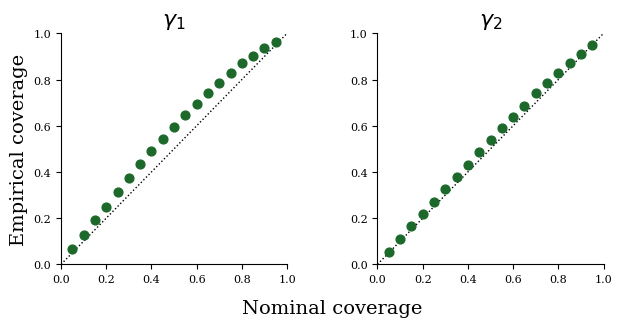

In [8]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting1.png"
)

**Plot 90% credible intervals**

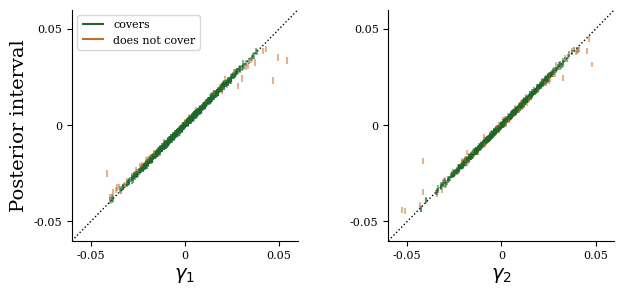

In [9]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting1.png"
)

### **Setting 2**

In [10]:
setting2 = torch.load("npe_credible_intervals_setting2.pt", weights_only=False)

confidence_levels = setting2["confidence_levels"]
shear1_true = setting2["shear1_true"]
shear2_true = setting2["shear2_true"]
shear1_ci_lower = setting2["shear1_ci_lower"]
shear1_ci_upper = setting2["shear1_ci_upper"]
shear2_ci_lower = setting2["shear2_ci_lower"]
shear2_ci_upper = setting2["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0483, Shear 2: 0.0451
Confidence level: 0.10, Shear 1: 0.0969, Shear 2: 0.0912
Confidence level: 0.15, Shear 1: 0.1430, Shear 2: 0.1424
Confidence level: 0.20, Shear 1: 0.1949, Shear 2: 0.1891
Confidence level: 0.25, Shear 1: 0.2488, Shear 2: 0.2381
Confidence level: 0.30, Shear 1: 0.2985, Shear 2: 0.2859
Confidence level: 0.35, Shear 1: 0.3478, Shear 2: 0.3321
Confidence level: 0.40, Shear 1: 0.3961, Shear 2: 0.3806
Confidence level: 0.45, Shear 1: 0.4456, Shear 2: 0.4301
Confidence level: 0.50, Shear 1: 0.5005, Shear 2: 0.4803
Confidence level: 0.55, Shear 1: 0.5511, Shear 2: 0.5260
Confidence level: 0.60, Shear 1: 0.5990, Shear 2: 0.5756
Confidence level: 0.65, Shear 1: 0.6490, Shear 2: 0.6244
Confidence level: 0.70, Shear 1: 0.6992, Shear 2: 0.6732
Confidence level: 0.75, Shear 1: 0.7486, Shear 2: 0.7226
Confidence level: 0.80, Shear 1: 0.7964, Shear 2: 0.7714
Confidence level: 0.85, Shear 1: 0.8449, Shear 2: 0.8216
Confidence level: 0.90, Shear 1

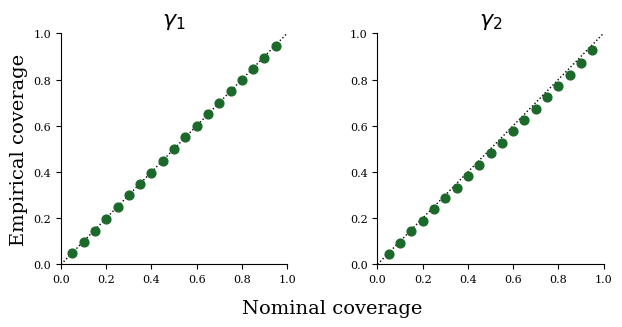

In [11]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting2.png"
)

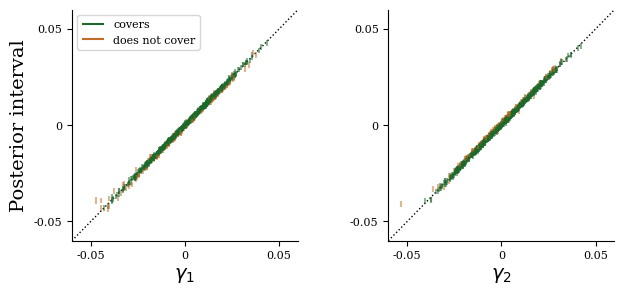

In [12]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting2.png"
)

### **Setting 3**

In [13]:
setting3 = torch.load("npe_credible_intervals_setting3.pt", weights_only=False)

confidence_levels = setting3["confidence_levels"]
shear1_true = setting3["shear1_true"]
shear2_true = setting3["shear2_true"]
shear1_ci_lower = setting3["shear1_ci_lower"]
shear1_ci_upper = setting3["shear1_ci_upper"]
shear2_ci_lower = setting3["shear2_ci_lower"]
shear2_ci_upper = setting3["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0528, Shear 2: 0.0404
Confidence level: 0.10, Shear 1: 0.1051, Shear 2: 0.0829
Confidence level: 0.15, Shear 1: 0.1553, Shear 2: 0.1235
Confidence level: 0.20, Shear 1: 0.2117, Shear 2: 0.1625
Confidence level: 0.25, Shear 1: 0.2673, Shear 2: 0.2043
Confidence level: 0.30, Shear 1: 0.3182, Shear 2: 0.2449
Confidence level: 0.35, Shear 1: 0.3739, Shear 2: 0.2853
Confidence level: 0.40, Shear 1: 0.4286, Shear 2: 0.3278
Confidence level: 0.45, Shear 1: 0.4855, Shear 2: 0.3676
Confidence level: 0.50, Shear 1: 0.5345, Shear 2: 0.4084
Confidence level: 0.55, Shear 1: 0.5843, Shear 2: 0.4494
Confidence level: 0.60, Shear 1: 0.6348, Shear 2: 0.4950
Confidence level: 0.65, Shear 1: 0.6814, Shear 2: 0.5416
Confidence level: 0.70, Shear 1: 0.7283, Shear 2: 0.5905
Confidence level: 0.75, Shear 1: 0.7761, Shear 2: 0.6393
Confidence level: 0.80, Shear 1: 0.8202, Shear 2: 0.6907
Confidence level: 0.85, Shear 1: 0.8635, Shear 2: 0.7452
Confidence level: 0.90, Shear 1

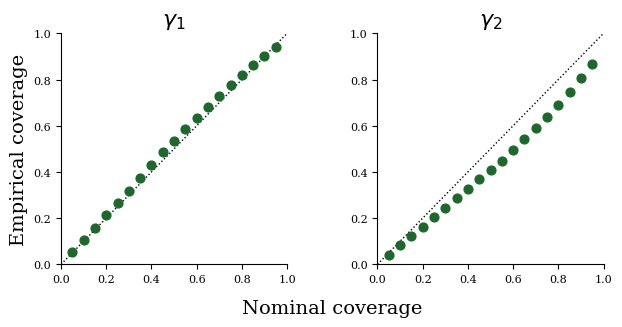

In [14]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting3.png"
)

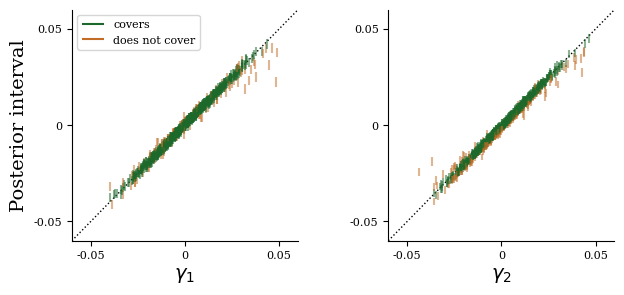

In [15]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting3.png"
)

### **Setting 4**

In [16]:
setting4 = torch.load("npe_credible_intervals_setting4.pt", weights_only=False)

confidence_levels = setting4["confidence_levels"]
shear1_true = setting4["shear1_true"]
shear2_true = setting4["shear2_true"]
shear1_ci_lower = setting4["shear1_ci_lower"]
shear1_ci_upper = setting4["shear1_ci_upper"]
shear2_ci_lower = setting4["shear2_ci_lower"]
shear2_ci_upper = setting4["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0580, Shear 2: 0.0608
Confidence level: 0.10, Shear 1: 0.1130, Shear 2: 0.1266
Confidence level: 0.15, Shear 1: 0.1710, Shear 2: 0.1899
Confidence level: 0.20, Shear 1: 0.2275, Shear 2: 0.2513
Confidence level: 0.25, Shear 1: 0.2816, Shear 2: 0.3157
Confidence level: 0.30, Shear 1: 0.3378, Shear 2: 0.3801
Confidence level: 0.35, Shear 1: 0.3907, Shear 2: 0.4440
Confidence level: 0.40, Shear 1: 0.4455, Shear 2: 0.4979
Confidence level: 0.45, Shear 1: 0.5016, Shear 2: 0.5543
Confidence level: 0.50, Shear 1: 0.5574, Shear 2: 0.6076
Confidence level: 0.55, Shear 1: 0.6048, Shear 2: 0.6609
Confidence level: 0.60, Shear 1: 0.6538, Shear 2: 0.7134
Confidence level: 0.65, Shear 1: 0.7069, Shear 2: 0.7602
Confidence level: 0.70, Shear 1: 0.7542, Shear 2: 0.8067
Confidence level: 0.75, Shear 1: 0.8048, Shear 2: 0.8470
Confidence level: 0.80, Shear 1: 0.8467, Shear 2: 0.8850
Confidence level: 0.85, Shear 1: 0.8867, Shear 2: 0.9168
Confidence level: 0.90, Shear 1

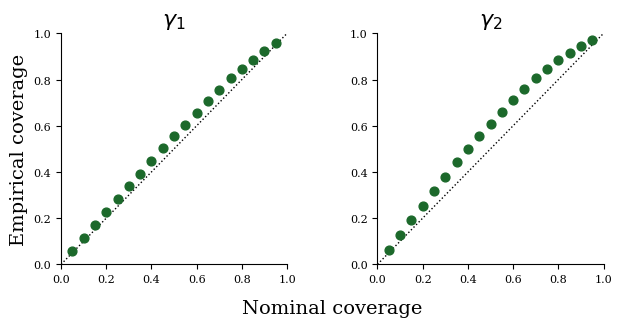

In [17]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting4.png"
)

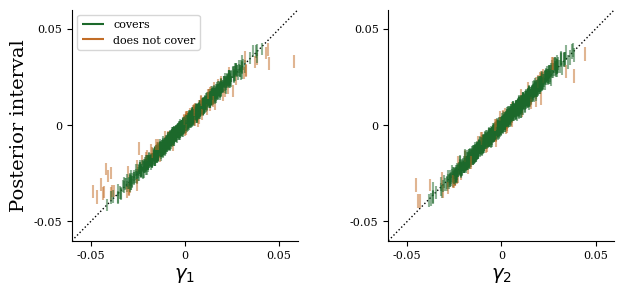

In [18]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting4.png"
)

### **Setting 5**

In [19]:
setting5 = torch.load("npe_credible_intervals_setting5.pt", weights_only=False)

confidence_levels = setting5["confidence_levels"]
shear1_true = setting5["shear1_true"]
shear2_true = setting5["shear2_true"]
shear1_ci_lower = setting5["shear1_ci_lower"]
shear1_ci_upper = setting5["shear1_ci_upper"]
shear2_ci_lower = setting5["shear2_ci_lower"]
shear2_ci_upper = setting5["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0486, Shear 2: 0.0598
Confidence level: 0.10, Shear 1: 0.1009, Shear 2: 0.1159
Confidence level: 0.15, Shear 1: 0.1527, Shear 2: 0.1745
Confidence level: 0.20, Shear 1: 0.2070, Shear 2: 0.2318
Confidence level: 0.25, Shear 1: 0.2576, Shear 2: 0.2919
Confidence level: 0.30, Shear 1: 0.3073, Shear 2: 0.3485
Confidence level: 0.35, Shear 1: 0.3555, Shear 2: 0.4036
Confidence level: 0.40, Shear 1: 0.4090, Shear 2: 0.4581
Confidence level: 0.45, Shear 1: 0.4583, Shear 2: 0.5130
Confidence level: 0.50, Shear 1: 0.5061, Shear 2: 0.5670
Confidence level: 0.55, Shear 1: 0.5560, Shear 2: 0.6173
Confidence level: 0.60, Shear 1: 0.6020, Shear 2: 0.6677
Confidence level: 0.65, Shear 1: 0.6488, Shear 2: 0.7155
Confidence level: 0.70, Shear 1: 0.6970, Shear 2: 0.7610
Confidence level: 0.75, Shear 1: 0.7413, Shear 2: 0.8019
Confidence level: 0.80, Shear 1: 0.7853, Shear 2: 0.8414
Confidence level: 0.85, Shear 1: 0.8287, Shear 2: 0.8770
Confidence level: 0.90, Shear 1

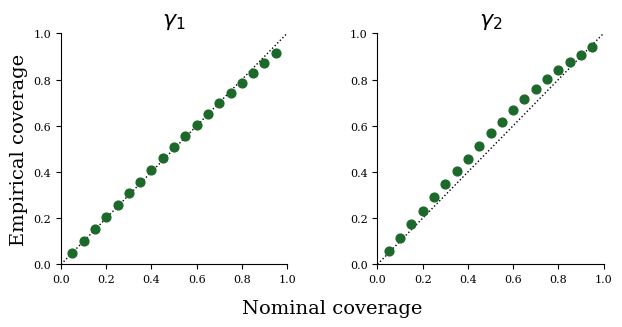

In [20]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting5.png"
)

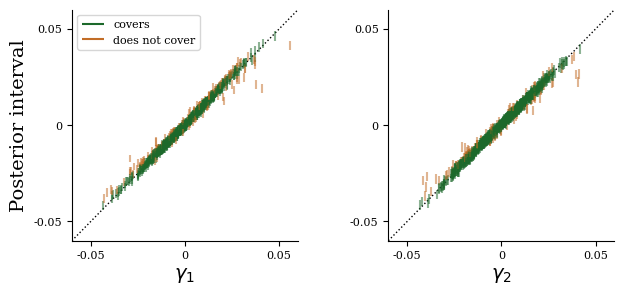

In [21]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting5.png"
)